In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
BASE_PATH = Path(".").absolute().parent.parent.parent

sys.path.append(str(BASE_PATH))

DATA_PATH = BASE_PATH / "sources" / "1917jps-wikisource"
TEXT_PATH = DATA_PATH / "text"
CREDITS_PATH = DATA_PATH / "credits"
SCHEMA_PATH = BASE_PATH / "schema"
SCHEMA_DOCUMENTATION_PATH = SCHEMA_PATH / "JLPTEI-3.md"
SCHEMA_ODD_PATH = SCHEMA_PATH / "jlptei.odd.xml"
SCHEMA_RNG_PATH = SCHEMA_PATH / "jlptei.odd.xml.relaxng"
VECTOR_DB_PATH = BASE_PATH / "private" /"jlptei_vector_db"

with open(BASE_PATH / "opensiddur" / "private" / "api_key.txt", "r") as f:
    API_KEY = f.read().strip()


# Agents

Outline agent:
- Given access to an entire large document, build an outline
- with tools: next_page, web_lookup?
Index agent:
- Input is the outline, use the first level to build a project index document containing a header, front matter, text (inclusions of other documents), back matter 
- Output is a JLPTEI valid project index file
- Tools:
  * JLPTEI RAG reference
XML Linter agent:
- Input is XML
- Output is a fixed/valid JLPTEI XML file
- Tools
  * xml lint tool
  * JLPTEI RAG reference
Header agent:
- Prompt contains a preformatted header
- Input is the document front matter,
- Output is a JLPTEI teiHeader structure
Source agent:
- Input is the title and outline + document pages
- Output is a JLPTEI-valid XML file containing only a subset of the final project
- Tools:
  * xml lint tool
  * JLPTEI RAG
  * Source reader
JLPTEI RAG reference agent/tool:
- Answer questions about how to encode in JLPTEI

In [2]:

# --- RAG vector DB setup for JLPTEI-3.md and jlptei.odd.xml ---

from pathlib import Path
import shutil

# We'll use Chroma as a simple local vector DB and OpenAI embeddings for demonstration.
# If you want to use another embedding model or DB, adjust accordingly.
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from openai import OpenAI

class OpenAIEmbeddingAdapter:
    def __init__(self, 
        base_url: str = "https://api.deepinfra.com/v1/openai", 
        model: str = "sentence-transformers/all-MiniLM-L12-v2"):
        self.client = OpenAI(api_key=API_KEY, base_url=base_url)
        self.model = model
    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        texts = [str(t) for t in texts if isinstance(t, str) and t.strip()]
        resp = self.client.embeddings.create(model=self.model, input=texts, encoding_format="float")
        return [d.embedding for d in resp.data]
    def embed_query(self, text: str) -> list[float]:
        resp = self.client.embeddings.create(model=self.model, input=str(text), encoding_format="float")
        return resp.data[0].embedding

def build_jlptei_vector_db(
    persist_directory: Path = VECTOR_DB_PATH
):
    """
    Build a Chroma vector DB for JLPTEI-3.md and jlptei.odd.xml for RAG.
    Returns the vectorstore object.
    """
    # Load and split both files
    md_docs = TextLoader(str(SCHEMA_DOCUMENTATION_PATH), autodetect_encoding=True).load()
    odd_docs = TextLoader(str(SCHEMA_ODD_PATH), autodetect_encoding=True).load()

    # split to strings
    splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50)
    docs = [d for d in splitter.split_documents(md_docs + odd_docs) 
        if isinstance(d.page_content, str) and d.page_content.strip()]
    
    # Use OpenAI embeddings (or swap for another embedding model if needed)
    embeddings = OpenAIEmbeddingAdapter()
    # rebuild store (wipe old incompatible data)
    if persist_directory.exists():
        shutil.rmtree(persist_directory)
    else:
        persist_directory.mkdir(parents=True, exist_ok=True)
    # Create or load the Chroma vectorstore
    vectordb = Chroma.from_documents(
        docs,
        embedding=embeddings,
        persist_directory=str(persist_directory)
    )

    return vectordb

# Example usage:
# jlptei_md = Path("schema/JLPTEI-3.md")
# jlptei_odd = Path("schema/jlptei.odd.xml")
# db = build_jlptei_vector_db(jlptei_md, jlptei_odd)

# To perform a similarity search:
# results = db.similarity_search("How are conditional blocks marked in JLPTEI?", k=3)
# for doc in results:
#     print(doc.page_content)


In [3]:
vectordb = build_jlptei_vector_db()

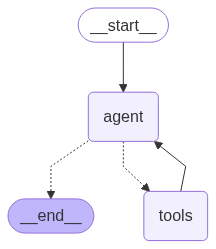

In [12]:
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import OpenAI

# Tool to answer questions about JLPTEI XML encoding using documentation
@tool("jlptei_reference", return_direct=False)
def jlptei_reference_tool(query: str) -> str | list[str]:
    """
    Answers questions about JLPTEI XML encoding using the documentation in ../../schemas/JLPTEI-3.md and ../../schemas/jlptei.odd.xml.
    """
    try:
        results = vectordb.similarity_search(query, k=3)
        if not results:
            return "No relevant information found in the JLPTEI documentation."
        answer = [doc.page_content for doc in results]
        return answer
    except Exception as e:
        return f"Error searching JLPTEI documentation: {e}"

# Define the prompt for the ReAct agent
react_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful agent that answers questions about encoding Jewish liturgy in XML
using the Open Siddur Project's JLPTEI schema. You have available to you a reference tool 
that can provide you with documentation and the schema as TEI ODD.

Important instructions:
- Think carefully and step by step about the question asked and what relevant information might be needed.
- Ask the tool for information you need about JLPTEI.
- You return precise responses that summarize only the most relevant information that you obtain from your tools.
- You must always prioritize the reference guidelines over your own knowledge of TEI.
- If you do not get a complete answer to your query the first time, ask the tool a followup question.
"""),
("placeholder", "{messages}")
    ])


from langchain_openai.chat_models.base import ChatOpenAI

# Create the ReAct agent
llm = ChatOpenAI(
    base_url="https://api.deepinfra.com/v1/openai",
    api_key=API_KEY,
    model="nvidia/Llama-3.1-Nemotron-70B-Instruct",
    temperature=0,
)
tools = [jlptei_reference_tool]
react_agent = create_react_agent(model=llm, tools=tools, name="reference_agent")

from IPython.display import Image, display
display(Image(react_agent.get_graph().draw_mermaid_png()))


In [13]:
inputs = { "messages": [
    {"role":"user", "content": "Encode Genesis 1:1 in JLPTEI"},
]}
messages = []
for chunk in react_agent.stream(inputs, stream_mode="updates"):
    messages.append(chunk)
    print(chunk)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Iba8iDb2ZBDE6yGCGsVEHCJ1', 'function': {'arguments': '{"query": "How to encode a biblical verse, specifically Genesis 1:1, in JLPTEI XML?"}', 'name': 'jlptei_reference'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 607, 'prompt_tokens': 276, 'total_tokens': 883, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'estimated_cost': 0.00021522}, 'model_name': 'nvidia/Llama-3.1-Nemotron-70B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-RsHEHBXZ9OG4MhkCJts0rNen', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='reference_agent', id='run--3e3f4ded-8e2f-4227-8a14-07b6cd205d6a-0', tool_calls=[{'name': 'jlptei_reference', 'args': {'query': 'How to encode a biblical verse, specifically Genesis 1:1, in JLPTEI XML?'}, 'id': 'call_Iba8iDb2ZBDE6yGCGsVEHCJ1', 'type': 'tool_call'}], usage_metadata={'input_t

In [ ]:
llm = ChatOpenAI(
    base_url="https://api.deepinfra.com/v1/openai",
    api_key=API_KEY,
    model="nvidia/Llama-3.1-Nemotron-70B-Instruct",
    temperature=0,
)

with open(SCHEMA_DOCUMENTATION_PATH, "r") as f:
    documentation = f.read()

prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a wise and insightful reader, 
a superlative expert the digital humanities,
knowledgable in XML and XML standards,
who answers questions concisely and accurately 
based on the documents you are given.

You only provide XML code, without any additional explanation or comments.

Your reference document is:
{documentation}
"""),
("placeholder", "{messages}")
]).partial(documentation=documentation)
prompted  = prompt | llm

messages = prompted.invoke({"messages": [
    {"role":"user", "content": "How do I  encode the biblical verse Genesis 1:1"},
]})

In [17]:
messages


AIMessage(content='Based on the provided JLPTEI (Jewish Liturgy Project TEI) guidelines, here\'s how you can encode the biblical verse Genesis 1:1:\n\n```xml\n<tei:div type="book">\n   <tei:head xml:lang="he">בראשית</tei:head> <!-- Book of Genesis in Hebrew -->\n   <tei:milestone unit="chapter" n="1" corresp="urn:x-opensiddur:text:bible:genesis/1"/>\n   <tei:milestone unit="verse" n="1" corresp="urn:x-opensiddur:text:bible:genesis/1/1"/>\n   <tei:p xml:lang="he">בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ</tei:p>\n   <!-- Optional: Transliteration or Translation can be added here, \n        e.g., using <tei:lg> for poetry or <tei:p> for prose, \n        with the respective language code (e.g., @xml:lang="en") -->\n   <!-- Example for Transliteration (using the provided transliteration scheme) -->\n   <!--<tei:p xml:lang="en" type="transliteration">Bereshit bara Elohim et hashamayim ve\'et ha\'aretz</tei:p>-->\n</tei:div>\n```\n\n**Breakdown:**\n\n1. **Book Division

In [ ]:
from opensiddur.converters.agent.tools import get_page
from project_header import project_header, ProjectHeaderInput, ProjectHeaderOutput

front_matter = "\n\n".join([
    get_page.invoke({"page_number":page}).content 
    for page in range(7, 10)] )

input = ProjectHeaderInput(
    namespace = "bible",
    top_level_entrypoint = "tanakh",
    project_id = "jps1917",
    front_matter = front_matter
    about_transcription = "Transcribed on Wikisource at https://en.wikisource.org/wiki/Bible_(Jewish_Publication_Society_1917) - Downloaded on Aug 22, 2025"
)
output = project_header(input)

In [24]:
print(output.header)

<tei:teiHeader xmlns:tei="http://www.tei-c.org/ns/1.0" xmlns:j="http://jewishliturgy.org/ns/jlptei/2">
    <tei:fileDesc>
        <tei:titleStmt>
            <tei:title type="main" xml:lang="en">THE HOLY SCRIPTURES</tei:title>
            <tei:title type="sub" xml:lang="en">ACCORDING TO THE MASORETIC TEXT</tei:title>
            <tei:title type="sub" xml:lang="en">A NEW TRANSLATION</tei:title>
            <tei:title type="alt" xml:lang="he">תורה נביאים וכתובים</tei:title>
        </tei:titleStmt>
        <tei:publicationStmt>
            <tei:distributor>
               <tei:ref target="http://opensiddur.org">Open Siddur Project</tei:ref>
            </tei:distributor>
            <tei:idno type="urn">urn:x-opensiddur:text:bible:tanakh@jps1917</tei:idno>
            <tei:availability status="free">
               <tei:licence target="http://www.creativecommons.org/publicdomain/zero/1.0/">Creative Commons Zero Public Domain Declaration</tei:licence>
            </tei:availability>
     

In [3]:
from opensiddur.converters.agent.xml_linter import rng_with_start, XMLLinterInput, XMLLinterOutput

print(rng_with_start("tei:teiHeader"))

<?xml version="1.0" encoding="UTF-8"?><grammar xmlns="http://relaxng.org/ns/structure/1.0" xmlns:tei="http://www.tei-c.org/ns/1.0" xmlns:teix="http://www.tei-c.org/ns/Examples" xmlns:xlink="http://www.w3.org/1999/xlink" datatypeLibrary="http://www.w3.org/2001/XMLSchema-datatypes" ns="http://www.tei-c.org/ns/1.0"><!--
Schema generated from ODD source 2025-09-07T07:16:43Z. .
TEI Edition: Version 4.6.0. Last updated on
        4th April 2023, revision 2129d5947
TEI Edition Location: https://www.tei-c.org/Vault/P5/Version 4.6.0/
  
--><!--This material is dual-licensed.
[http://creativecommons.org/licenses/by-sa/3.0/] Distributed under a Creative Commons Attribution-ShareAlike 3.0 Unported License  [http://www.opensource.org/licenses/BSD-2-Clause] Copyright 2013 TEI Consortium. All rights reserved. Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met: Redistributions of source code must retain the abov

In [2]:
from opensiddur.converters.agent.xml_linter import xml_linter, XMLLinterInput, XMLLinterOutput


valid_header = """<tei:teiHeader xmlns:tei="http://www.tei-c.org/ns/1.0">
      <tei:fileDesc>
         <tei:titleStmt>
            <tei:title type="main" xml:lang="en">2 Chronicles</tei:title>
            <tei:title type="alt" xml:lang="he">דברי הימים ב</tei:title>
         </tei:titleStmt>
         <tei:editionStmt>
            <tei:p>See <tei:ref target="urn:x-opensiddur:bible:tanakh@wlc">WLC Tanakh header for version information</tei:ref>
            </tei:p>
         </tei:editionStmt>
         <tei:publicationStmt>
            <tei:distributor>
               <tei:ref target="http://opensiddur.org">Open Siddur Project</tei:ref>
            </tei:distributor>
            <tei:idno type="urn">urn:x-opensiddur:text:bible:2_chronicles@wlc</tei:idno>
            <tei:availability status="free">
               <tei:licence target="http://www.creativecommons.org/publicdomain/zero/1.0/">Creative Commons Zero Public Domain Declaration (CC0)</tei:licence>
            </tei:availability>
         </tei:publicationStmt>
         <tei:sourceDesc>
            <tei:p>See <tei:ref cRef="bad" target="urn:x-opensiddur:text:bible:tanakh@wlc">WLC Tanakh header for source information</tei:ref>
            </tei:p>
         </tei:sourceDesc>
      </tei:fileDesc>
   </tei:teiHeader>"""

xml_linter_input = XMLLinterInput(xml=valid_header, start_element="tei:teiHeader")
xml_linter_output = xml_linter(xml_linter_input)
print(xml_linter_output.errors)
print(xml_linter_output.explanation)


["Only one of the\n\tattributes @target' and @cRef' may be supplied on tei:ref"]
The XML is invalid
